In [2]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout 
from tensorflow.keras.layers import Concatenate, GaussianNoise, Lambda
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU
from sklearn import preprocessing

2024-10-07 06:56:33.278426: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 06:56:33.280747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 06:56:33.284116: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 06:56:33.293571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 06:56:33.309232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
# Pull the data from the feature store sorted by date and then store number
sales_features_store_df = get_store_dataset_from_offline_feature_group_date_sort(store_sales_feature_group)
sales_features_store_df.head()

Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728164033"
    ORDER BY
        date ASC, store_nbr ASC
    


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2013-01-01,1,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:1,1.728164e+09,2024-10-05 21:39:49.912,2024-10-05 21:34:48.000,False
1,2013-01-01,2,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:2,1.728164e+09,2024-10-05 21:39:50.076,2024-10-05 21:34:48.000,False
2,2013-01-01,3,0.0,93.14,0,1,18,12,8,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:3,1.728164e+09,2024-10-05 21:39:49.967,2024-10-05 21:34:48.000,False
3,2013-01-01,4,0.0,93.14,0,1,18,12,9,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:4,1.728164e+09,2024-10-05 21:39:50.013,2024-10-05 21:34:48.000,False
4,2013-01-01,5,0.0,93.14,0,1,21,14,4,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:5,1.728164e+09,2024-10-05 21:39:50.068,2024-10-05 21:34:48.000,False


In [4]:
# Drop miscellaneous info
sales_features_store_df.drop(columns=["sales_record_id", "event_time", "write_time", "api_invocation_time", "is_deleted"], inplace=True)

In [7]:
sales_features_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90936 entries, 0 to 90935
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                90936 non-null  object 
 1   store_nbr           90936 non-null  int64  
 2   sales               90936 non-null  float64
 3   oil                 90936 non-null  float64
 4   onpromotion         90936 non-null  int64  
 5   is_holiday          90936 non-null  int64  
 6   city                90936 non-null  int64  
 7   state               90936 non-null  int64  
 8   cluster             90936 non-null  int64  
 9   year                90936 non-null  int64  
 10  month               90936 non-null  int64  
 11  day                 90936 non-null  int64  
 12  dow                 90936 non-null  int64  
 13  city-state          90936 non-null  object 
 14  city-state-cluster  90936 non-null  object 
 15  hash_0              90936 non-null  float64
 16  hash

In [8]:
# Perform feature selection
def get_store_features(row):
    return [
      row["sales"], 
      row["oil"], 
      row["onpromotion"],
      # row["is_holiday"], 
      # row["hash_0"], 
      # row["hash_1"], 
      # row["hash_2"], 
      # row["hash_3"], 
      # row["hash_4"], 
      # row["hash_5"], 
      # row["hash_6"], 
      # row["hash_7"], 
      # row["hash_8"], 
      # row["hash_9"], 
      row["month_cos"],
      row["month_sin"],
      row["day_cos"],
      row["day_sin"],
      # row["dow_cos"],
      # row["dow_sin"]
]

sales_features_store_df.head().apply(get_store_features, axis=1)

0    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
1    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
2    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
3    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
4    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
dtype: object

In [9]:
# Apply to the whole dataframe
sales_features_store_df["features"] = sales_features_store_df.apply(get_store_features, axis=1)

In [10]:
# Drop everything except the store number, date, and selected features
drop_columns = [col for col in sales_features_store_df.columns if col not in ["date", "store_nbr", "features"]]
sales_features_store_df.drop(columns=drop_columns, inplace=True)
sales_features_store_df.head()

,date,store_nbr,features
0,2013-01-01,1,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
1,2013-01-01,2,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
2,2013-01-01,3,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
3,2013-01-01,4,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
4,2013-01-01,5,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."


In [11]:
# Pivot the data to be in the format (store number, date, features)
sales_data_pivoted = sales_features_store_df.pivot(index="store_nbr", columns="date", values="features")
sales_data_pivoted.head()

date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[7417.15, 93.14, 0, 0.8660254037844387, 0.4999...","[5873.24, 92.97, 0, 0.8660254037844387, 0.4999...","[5919.88, 93.12, 0, 0.8660254037844387, 0.4999...","[6318.79, 93.12, 0, 0.8660254037844387, 0.4999...","[2199.09, 93.12, 0, 0.8660254037844387, 0.4999...","[6150.92, 93.2, 0, 0.8660254037844387, 0.49999...","[5597.18, 93.21, 0, 0.8660254037844387, 0.4999...","[6808.58, 93.08, 0, 0.8660254037844387, 0.4999...","[4757.71, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[4409.25, 49.57, 29, -0.5000000000000004, -0.8...","[10538.14, 49.37, 44, -0.5000000000000004, -0....","[11070.76, 49.07, 35, -0.5000000000000004, -0....","[12583.65, 49.59, 212, -0.5000000000000004, -0...","[10834.58, 48.54, 31, -0.5000000000000004, -0....","[5403.74, 48.81, 38, -0.5000000000000004, -0.8...","[7543.62, 48.81, 28, -0.5000000000000004, -0.8...","[3902.78, 48.81, 19, -0.5000000000000004, -0.8...","[10433.31, 47.59, 30, -0.5000000000000004, -0....","[9823.55, 47.57, 29, -0.5000000000000004, -0.8..."
2,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[10266.72, 93.14, 0, 0.8660254037844387, 0.499...","[7612.54, 92.97, 0, 0.8660254037844387, 0.4999...","[7526.38, 93.12, 0, 0.8660254037844387, 0.4999...","[9539.57, 93.12, 0, 0.8660254037844387, 0.4999...","[10322.39, 93.12, 0, 0.8660254037844387, 0.499...","[6675.97, 93.2, 0, 0.8660254037844387, 0.49999...","[6109.57, 93.21, 0, 0.8660254037844387, 0.4999...","[6740.52, 93.08, 0, 0.8660254037844387, 0.4999...","[5565.04, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[16987.57, 49.57, 43, -0.5000000000000004, -0....","[12382.45, 49.37, 39, -0.5000000000000004, -0....","[11304.55, 49.07, 38, -0.5000000000000004, -0....","[12615.75, 49.59, 213, -0.5000000000000004, -0...","[11317.83, 48.54, 26, -0.5000000000000004, -0....","[13081.77, 48.81, 57, -0.5000000000000004, -0....","[12382.42, 48.81, 33, -0.5000000000000004, -0....","[13766.82, 48.81, 32, -0.5000000000000004, -0....","[12211.46, 47.59, 36, -0.5000000000000004, -0....","[11196.26, 47.57, 33, -0.5000000000000004, -0...."
3,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[24060.35, 93.14, 0, 0.8660254037844387, 0.499...","[18570.75, 92.97, 0, 0.8660254037844387, 0.499...","[17392.1, 93.12, 0, 0.8660254037844387, 0.4999...","[22700.87, 93.12, 0, 0.8660254037844387, 0.499...","[25343.62, 93.12, 0, 0.8660254037844387, 0.499...","[17036.25, 93.2, 0, 0.8660254037844387, 0.4999...","[14220.42, 93.21, 0, 0.8660254037844387, 0.499...","[14735.15, 93.08, 0, 0.8660254037844387, 0.499...","[12222.91, 93.81, 0, 0.8660254037844387, 0.499...",...,"[42005.37, 49.57, 43, -0.5000000000000004, -0....","[32074.15, 49.37, 41, -0.5000000000000004, -0....","[28450.84, 49.07, 40, -0.5000000000000004, -0....","[32962.39, 49.59, 222, -0.5000000000000004, -0...","[26035.93, 48.54, 30, -0.5000000000000004, -0....","[32885.76, 48.81, 67, -0.5000000000000004, -0....","[31903.48, 48.81, 34, -0.5000000000000004, -0....","[34845.12, 48.81, 36, -0.5000000000000004, -0....","[32843.7, 47.59, 34, -0.5000000000000004, -0.8...","[30185.6, 47.57, 33, -0.5000000000000004, -0.8..."
4,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[10200.08, 93.14, 0, 0.8660254037844387, 0.499...","[7400.25, 92.97, 0, 0.8660254037844387, 0.4999...","[6902.05, 93.12, 0, 0.8660254037844387, 0.4999...","[9948.38, 93.12, 0, 0.8660254037844387, 0.4999...","[11679.69, 93.12, 0, 0.8660254037844387, 0.499...","[6748.2, 93.2, 0, 0.8660254037844387, 0.499999...","[6017.61, 93.21, 0, 0.8660254037844387, 0.4999...","[5867.88, 93.08, 0, 0.8660254037844387, 0.4999...","[4674.25, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[16801.05, 49.57, 32, -0.5000000000000004, -0....","[10214.14, 49.37, 29, -

In [12]:
# Convert the data to an array
stacked_sales_data = np.array(sales_data_pivoted.values.tolist())
stacked_sales_data.shape

(54, 1684, 7)

In [19]:
# Split the data into test/train/val sets with a 60/20/20 split
n = stacked_sales_data.shape[1]
train_data = stacked_sales_data[:, :int(n*0.6), :]
test_data = stacked_sales_data[:, int(n*0.6):int(n*0.8), :]
val_data = stacked_sales_data[:, int(n*0.8):, :]
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (54, 1010, 7)
Test data shape: (54, 337, 7)
Validation data shape: (54, 337, 7)


In [20]:
# Get the mean and standard deviation for normalization
scaler = preprocessing.StandardScaler()
train_data_2d = train_data.reshape(-1, train_data.shape[2])
scaler.fit(train_data_2d[:, :3])

global_mean = scaler.mean_
global_stddev = scaler.scale_

print(global_mean, global_stddev)

# train_data_2d = train_data.reshape(-1, train_data.shape[2])
# test_data_2d = test_data.reshape(-1, test_data.shape[2])
# val_data_2d = val_data.reshape(-1, val_data.shape[2])

# train_data_2d[:, :3] = scaler.fit_transform(train_data_2d[:, :3])
# test_data_2d[:, :3] = scaler.transform(test_data_2d[:, :3])
# val_data_2d[:, :3] = scaler.transform(val_data_2d[:, :3])

# print(f"Train data shape (2D): {train_data_2d.shape}")
# print(f"Test data shape (2D): {test_data_2d.shape}")
# print(f"Validation data shape (2D): {val_data_2d.shape}\n")

# train_data = train_data_2d.reshape(train_data.shape)
# test_data = test_data_2d.reshape(test_data.shape)
# val_data = val_data_2d.reshape(val_data.shape)

# print(f"Train data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")
# print(f"Validation data shape: {val_data.shape}")

[9754.29461184   83.15427319   11.49229923] [8771.22271946   22.17583982   29.16430315]


In [21]:
# Define a function that breaks the data into time series windows of a specified size
# input_seq_length: The length of the input window
# target_seq_length: The length of the target (prediction) window
# stride: How much the windows overlap. A stride of 1 means each set of input/targets is shifted 1 day forward from the last input/targets
def generate_windows(data, input_seq_length, target_seq_length, stride):
    windows = []
    targets = []
    num_days = data.shape[1]
    
    for i in range(0, num_days, stride):
        if (i+input_seq_length+target_seq_length) <= num_days:
            input_window_end = i + input_seq_length
            target_window_end = input_window_end + target_seq_length
            
            input_window = data[:, i:input_window_end, :]
            target_window = data[:, input_window_end:target_window_end, 0]
            
            windows.append(input_window)
            targets.append(target_window)
            
    return np.array(windows), np.array(targets)

In [22]:
# Generate windows for train/test/val sets
input_seq_length = 14
target_seq_length = 7
stride = 1

train_inputs, train_targets = generate_windows(train_data, input_seq_length, target_seq_length, stride)
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train targets shape: {train_targets.shape}")

continuous_train_inputs = train_inputs[:, :, :, :3]
categorical_train_inputs = train_inputs[:, :, :, 3:]
print(f"Continuous train inputs shape: {continuous_train_inputs.shape}")
print(f"Categorical train inputs shape: {categorical_train_inputs.shape}\n")

test_inputs, test_targets = generate_windows(test_data, input_seq_length, target_seq_length, stride)
print(f"Test inputs shape: {test_inputs.shape}")
print(f"Test targets shape: {test_targets.shape}")

continuous_test_inputs = test_inputs[:, :, :, :3]
categorical_test_inputs = test_inputs[:, :, :, 3:]
print(f"Continuous test inputs shape: {continuous_test_inputs.shape}")
print(f"Categorical test inputs shape: {categorical_test_inputs.shape}\n")

val_inputs, val_targets = generate_windows(val_data, input_seq_length, target_seq_length, stride)
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation inputs shape: {val_targets.shape}")

continuous_val_inputs = val_inputs[:, :, :, :3]
categorical_val_inputs = val_inputs[:, :, :, 3:]
print(f"Continuous validation inputs shape: {continuous_val_inputs.shape}")
print(f"Categorical validation inputs shape: {categorical_val_inputs.shape}")

Train inputs shape: (990, 54, 14, 7)
Train targets shape: (990, 54, 7)
Continuous train inputs shape: (990, 54, 14, 3)
Categorical train inputs shape: (990, 54, 14, 4)

Test inputs shape: (317, 54, 14, 7)
Test targets shape: (317, 54, 7)
Continuous test inputs shape: (317, 54, 14, 3)
Categorical test inputs shape: (317, 54, 14, 4)

Validation inputs shape: (317, 54, 14, 7)
Validation inputs shape: (317, 54, 7)
Continuous validation inputs shape: (317, 54, 14, 3)
Categorical validation inputs shape: (317, 54, 14, 4)


In [21]:
# Baseline MLP model
# simple_mlp_model = Sequential([
#     Input(shape=(train_inputs.shape[1], train_inputs.shape[2], train_inputs.shape[3])),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(54 * train_targets.shape[2]),
#     Reshape(target_shape=(54, train_targets.shape[2]))
# ])

# simple_mlp_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

# print(simple_mlp_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 6048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       387,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 378)            │        24,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 54, 7)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,706 (1.57 MB)

 Trainable params: 411,706 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.9845 - mean_absolute_error: 0.6387 - val_loss: 1.7184 - val_mean_absolute_error: 0.7490
Epoch 2/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.5050 - mean_absolute_error: 0.4169 - val_loss: 1.4875 - val_mean_absolute_error: 0.7084
Epoch 3/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4063 - mean_absolute_error: 0.3794 - val_loss: 1.3682 - val_mean_absolute_error: 0.6839
Epoch 4/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3865 - mean_absolute_error: 0.3752 - val_loss: 1.3042 - val_mean_absolute_error: 0.6688
Epoch 5/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3518 - mean_absolute_error: 0.3671 - val_loss: 1.2600 - val_mean_absolute_error: 0.6536
Epoch 6/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3826 - mean_absolute_error: 0.3793 - val_loss: 1.2408 - val_mean_absolute_error: 0.6487
Epoch 7/10
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3702 - mean_absolute_error: 0.3757 - 

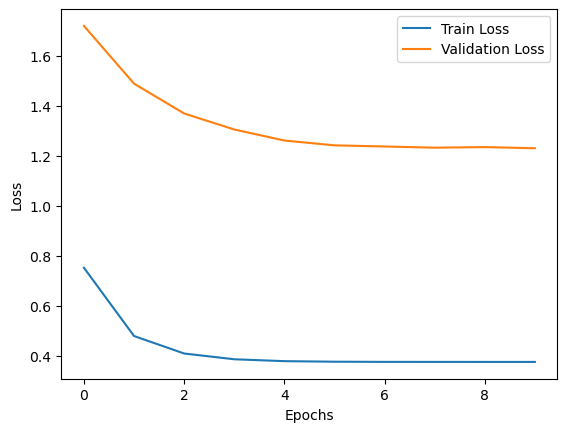

In [22]:
# # Fit the baseline model
# history = simple_mlp_model.fit(train_inputs, train_targets, validation_data=(test_inputs, test_targets), epochs=10, batch_size=1)

# # Plot the learning curves
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [23]:
# # Evaluate the baseline model on the validation set
# eval = simple_mlp_model.evaluate(val_inputs, val_targets)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3362 - mean_absolute_error: 0.74866


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 14, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 54, 14, 3) │          0 │ continuous_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 54, 14, 3) │          0 │ lambda_2[0][0]    │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 14, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 54, 14, 7) │          0 │ gaussian_noise_1… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 756, 7)    │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 8)         │        512 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 378)       │      3,402 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 54, 7)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 54, 7)     │          0 │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,914 (15.29 KB)

 Trainable params: 3,914 (15.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 75715040.0000 - mean_absolute_error: 5927.3179 - val_loss: 158319088.0000 - val_mean_absolute_error: 7262.0850
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 53884552.0000 - mean_absolute_error: 4505.7349 - val_loss: 126730120.0000 - val_mean_absolute_error: 6483.7749
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 35717264.0000 - mean_absolute_error: 3500.8013 - val_loss: 111175464.0000 - val_mean_absolute_error: 6126.7305
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 31094626.0000 - mean_absolute_error: 3346.4673 - val_loss: 103856640.0000 - val_mean_absolute_error: 5912.2061
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 27272506.0000 - mean_absolute_error: 3264.4270 - val_loss: 99248640.0000 - val_mean_absolute_error: 5766.2632
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 27019522.0000 - mean_absolute_error: 3260.6089 - val_loss: 97475312.0000 - 

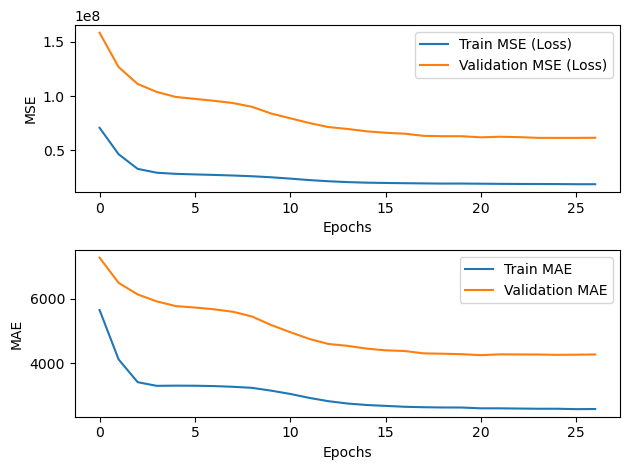

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 56921660.0000 - mean_absolute_error: 4438.5942


In [24]:
# LSTM model
lstm_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    min_delta=10,
    patience=6,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        continuous_train_inputs.shape[3]
    ), 
    name="continuous_input"
)

categorical_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        categorical_train_inputs.shape[3]
    ), 
    name="categorical_input"
)

global_mean_tf = tf.constant(global_mean, dtype=tf.float32)
global_stddev_tf = tf.constant(global_stddev, dtype=tf.float32)
target_mean_tf = tf.constant(global_mean[0], dtype=tf.float32)
target_stddev_tf = tf.constant(global_stddev[0], dtype=tf.float32)

normalized_input = Lambda(lambda x: (x - global_mean_tf) / global_stddev_tf)(continuous_input)
noisy_input = GaussianNoise(stddev=0.1)(normalized_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, train_inputs.shape[3]))(combined_inputs)
lstm = LSTM(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(reshaped)
dense = Dense(54 * train_targets.shape[2])(lstm)
outputs = Reshape(target_shape=(54, train_targets.shape[2]))(dense)
denormalized_outputs = Lambda(lambda x: x * target_stddev_tf + target_mean_tf)(outputs)


lstm_model = Model(inputs=[continuous_input, categorical_input], outputs=denormalized_outputs)

lstm_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

print(lstm_model.summary())


history = lstm_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=16, 
    callbacks=[lstm_es_callback]
)

fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

eval = lstm_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 14, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 54, 14, 3) │          0 │ continuous_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_3    │ (None, 54, 14, 3) │          0 │ lambda_6[0][0]    │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 14, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 54, 14, 7) │          0 │ gaussian_noise_3… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 756, 7)    │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        408 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 378)       │      3,402 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 54, 7)     │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 54, 7)     │          0 │ reshape_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,810 (14.88 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step - loss: 73955040.0000 - mean_absolute_error: 5730.6216 - val_loss: 140275072.0000 - val_mean_absolute_error: 6615.8770
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 38837540.0000 - mean_absolute_error: 3687.7437 - val_loss: 101506608.0000 - val_mean_absolute_error: 5602.3193
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 29378424.0000 - mean_absolute_error: 3341.3486 - val_loss: 83606872.0000 - val_mean_absolute_error: 4891.8760
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 25890104.0000 - mean_absolute_error: 3131.4221 - val_loss: 75262488.0000 - val_mean_absolute_error: 4549.2051
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 25611356.0000 - mean_absolute_error: 3134.6653 - val_loss: 72594232.0000 - val_mean_absolute_error: 4462.3169
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 25323368.0000 - mean_absolute_error: 3060.8689 - val_loss: 69713240.0000 - va

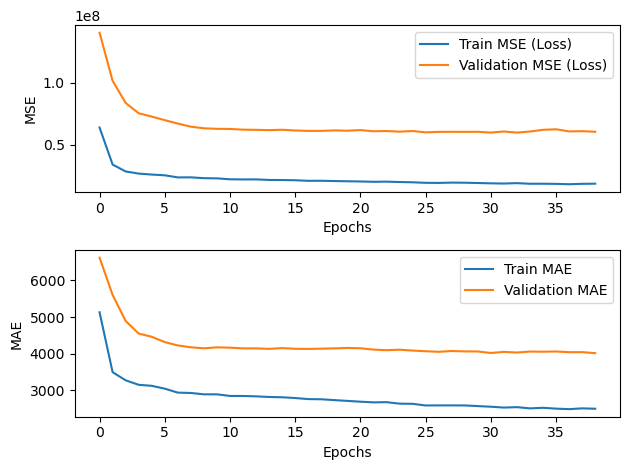

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 51878492.0000 - mean_absolute_error: 4258.7563


In [26]:
# GRU model
gru_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=10000,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        continuous_train_inputs.shape[3]
    ), 
    name="continuous_input"
)

categorical_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        categorical_train_inputs.shape[3]
    ), 
    name="categorical_input"
)

global_mean_tf = tf.constant(global_mean, dtype=tf.float32)
global_stddev_tf = tf.constant(global_stddev, dtype=tf.float32)
target_mean_tf = tf.constant(global_mean[0], dtype=tf.float32)
target_stddev_tf = tf.constant(global_stddev[0], dtype=tf.float32)

normalized_input = Lambda(lambda x: (x - global_mean_tf) / global_stddev_tf)(continuous_input)
noisy_input = GaussianNoise(stddev=0.1)(normalized_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, train_inputs.shape[3]))(combined_inputs)
gru = GRU(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(reshaped)
dropout = Dropout(0.2)(gru)
dense = Dense(54 * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(54, train_targets.shape[2]))(dense)
denormalized_outputs = Lambda(lambda x: x * target_stddev_tf + target_mean_tf)(outputs)

gru_model = Model(inputs=[continuous_input, categorical_input], outputs=denormalized_outputs)

gru_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.002))

print(gru_model.summary())


history = gru_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=16, 
    callbacks=[gru_es_callback]
)

fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

eval = gru_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)